In [4]:
#IMPORT OF ALL THE LIBRARIES

import numpy as np
import xlrd
from matplotlib.pyplot import *
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend, 
                           title, subplot, show, grid)
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate,feature_selector_lr, bmplot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from pandas.plotting import table
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as st 
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from toolbox_02450 import mcnemar, train_neural_net
from sklearn import model_selection  
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



In [5]:

#To load our data
df = pd.read_excel(r"C:\Users\stamg\Desktop\IntroToML\Concrete_Data.xls")

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to your data and transform it
X_standardized = scaler.fit_transform(df)

# Create a new DataFrame with the standardized data
df = pd.DataFrame(X_standardized, columns=df.columns)

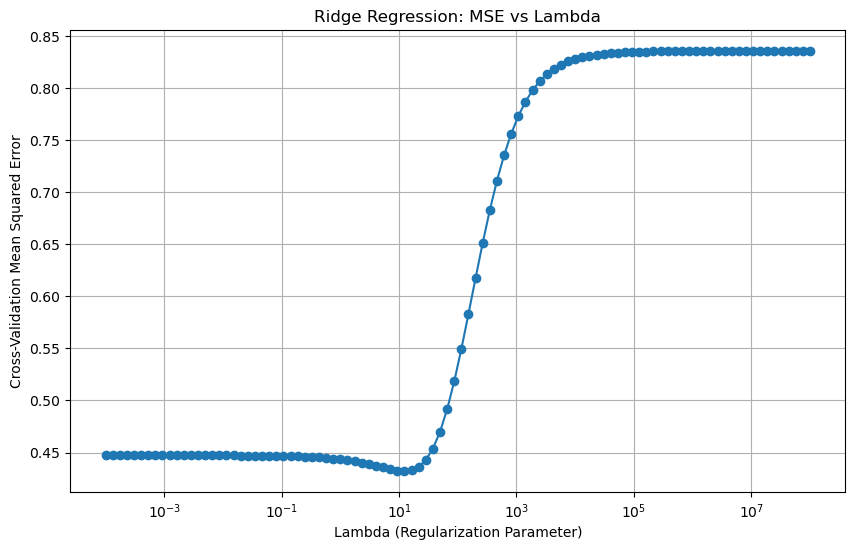

Optimal Lambda: 12.32846739442066

Feature Weights for the Optimal Lambda:
   Cement (component 1)(kg in a m^3 mixture)  \
0                                   0.331203   

   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
0                                           0.157547       

   Fly Ash (component 3)(kg in a m^3 mixture)  \
0                                   -0.017986   

   Water  (component 4)(kg in a m^3 mixture)  \
0                                  -0.222082   

   Superplasticizer (component 5)(kg in a m^3 mixture)  \
0                                           0.192248     

   Coarse Aggregate  (component 6)(kg in a m^3 mixture)  \
0                                           -0.11909      

   Fine Aggregate (component 7)(kg in a m^3 mixture)  Age (day)  
0                                          -0.096596    0.40266  


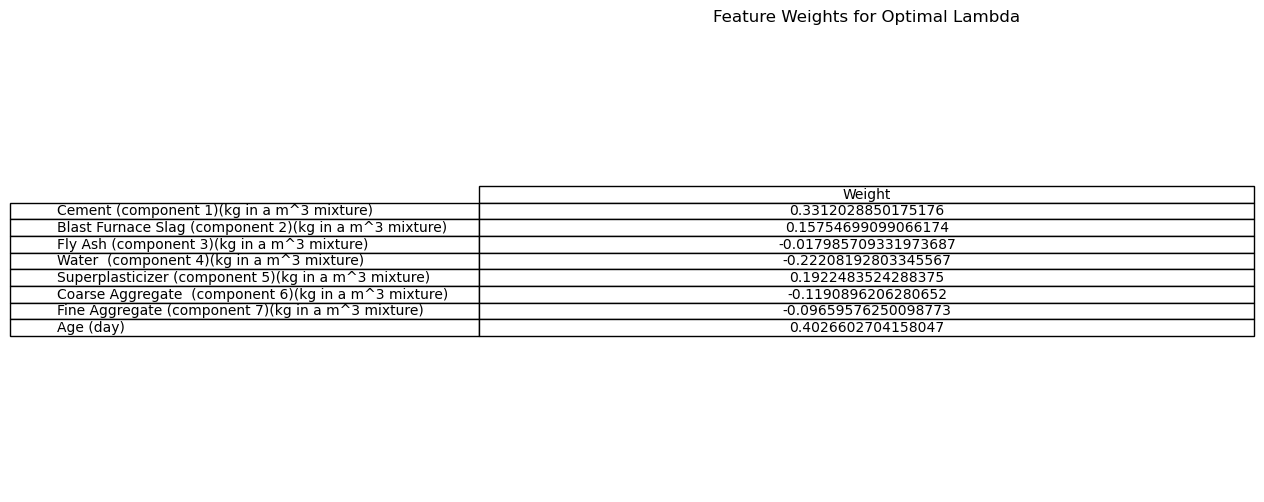

In [6]:
#Regression A


# Load your data (df should be defined before this point)

X = df.iloc[:, :8].values
y = df['Concrete compressive strength(MPa, megapascals) '].values

attributeNames = df.columns[:8].tolist()
N, M = X.shape

# Create cross-validation partition for evaluation
K = 20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.9, random_state=42)

# Standardize the training and set set based on the training set mean and std
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)

X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

# Define a range of lambda values
lambdas = np.logspace(-4, 8, 100)

# Initialize lists to store cross-validation scores and feature weights
cv_scores = []
feature_weights = []

# For each value of lambda
for lambda_ in lambdas:
    # Create a Ridge regressor with that lambda
    ridge = Ridge(alpha=lambda_)
    
    # Use GridSearchCV to perform cross-validation and get the best estimator
    grid_search = GridSearchCV(ridge, {'alpha': [lambda_]}, cv=10, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Get the best estimator from the grid search
    best_ridge = grid_search.best_estimator_
    
    # Append the coefficients (feature weights) to the list
    feature_weights.append(best_ridge.coef_)
    
    # Perform 10-fold cross-validation and store the mean squared error
    cv_score = cross_val_score(best_ridge, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
    
    # Append the score to the list of scores
    cv_scores.append(np.mean(np.abs(cv_score)))

# Plot the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(lambdas, cv_scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Parameter)')
plt.ylabel('Cross-Validation Mean Squared Error')
plt.title('Ridge Regression: MSE vs Lambda')
plt.grid(True)
plt.show()

# Find the optimal lambda that minimizes the cross-validation error
optimal_lambda_index = np.argmin(cv_scores)
optimal_lambda = lambdas[optimal_lambda_index]

# Display the optimal lambda
print("Optimal Lambda:", optimal_lambda)

# Display the feature weights for the optimal lambda
optimal_feature_weights = feature_weights[optimal_lambda_index]
feature_weights_df = pd.DataFrame([optimal_feature_weights], columns=attributeNames)
print("\nFeature Weights for the Optimal Lambda:")
print(feature_weights_df)
# Save the feature weights table as a figure
plt.figure(figsize=(10, 6))
plt.table(cellText=feature_weights_df.values.T,  # Transpose the data for 8 by 2 table
          rowLabels=feature_weights_df.columns,
          colLabels=['Weight'],
          cellLoc='center',
          loc='center')
plt.axis('off')
plt.title('Feature Weights for Optimal Lambda')
plt.savefig('feature_weights_table.png', bbox_inches='tight')
plt.show()

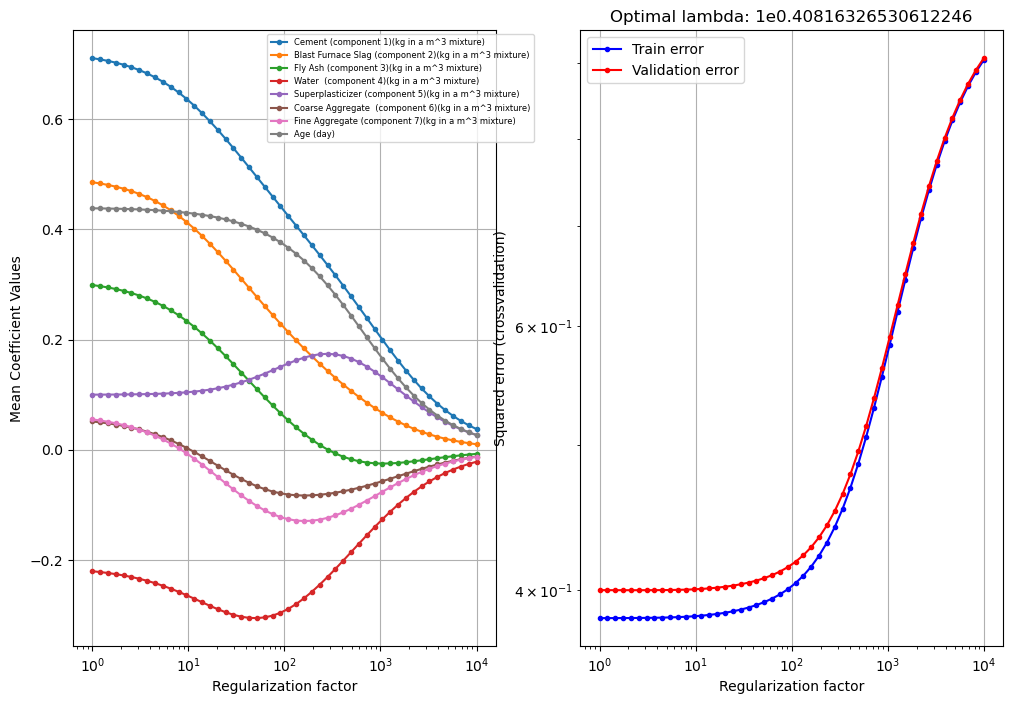

Linear regression without feature selection:
- Training error: 0.38395731428631236
- Test error:     0.3956533376401713
- R^2 train:     0.6160082551418442
- R^2 test:     0.6014520665551468

Regularized linear regression:
- Training error: 0.3840021694958506
- Test error:     0.3958320214815795
- R^2 train:     0.6159633959100085
- R^2 test:     0.6012720754645675

Weights in last fold:
         Offset           -0.01
Cement (component 1)(kg in a m^3 mixture)             0.7
Blast Furnace Slag (component 2)(kg in a m^3 mixture)            0.47
Fly Ash (component 3)(kg in a m^3 mixture)            0.29
Water  (component 4)(kg in a m^3 mixture)           -0.23
Superplasticizer (component 5)(kg in a m^3 mixture)             0.1
Coarse Aggregate  (component 6)(kg in a m^3 mixture)            0.04
Fine Aggregate (component 7)(kg in a m^3 mixture)            0.04
      Age (day)            0.44


In [7]:
#Regression part b


# 1. Implement two-lvl cross validation


X = df.iloc[:, :8].values

# 'Fly Ash (component 3)(kg in a m^3 mixture)' is your target variable
y = df['Concrete compressive strength(MPa, megapascals) '].values


attributeNames = df.columns[:8].tolist()
N,M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)

# Values of lambda
lambdas = np.logspace(0, 4, 50)

# Initialize variables and split dataset to test/train

Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
w_rlr = np.empty((M,K))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0


for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    internal_cross_validation = 10    #K1=K2=10
    
    opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]


    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr[:,k] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    
    
    # Compute mean squared error with regularization with optimal lambda
    Error_train_rlr[k] = np.square(y_train-X_train @ w_rlr[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test_rlr[k] = np.square(y_test-X_test @ w_rlr[:,k]).sum(axis=0)/y_test.shape[0]

    # Estimate weights for unregularized linear regression, on entire training set
    w_noreg[:,k] = np.linalg.solve(XtX,Xty).squeeze()
    # Compute mean squared error without regularization
    Error_train[k] = np.square(y_train-X_train @ w_noreg[:,k]).sum(axis=0)/y_train.shape[0]
    Error_test[k] = np.square(y_test-X_test @ w_noreg[:,k]).sum(axis=0)/y_test.shape[0]
    
    
    #ALTERNATIVELY: we can use sklearn.linear_model module for linear regression:
    #m = lm.LinearRegression().fit(X_train, y_train)
    #Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    #Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Display the results for the last cross-validation fold
    if k == K-1:
        figure(k, figsize=(12,8))
        subplot(1,2,1)
        semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'.-') # Don't plot the bias term
        xlabel('Regularization factor')
        ylabel('Mean Coefficient Values')
        legend(attributeNames[1:], prop={'size': 6}, bbox_to_anchor=(.45, 1), loc='upper left')
        grid()
        # You can choose to display the legend, but it's omitted for a cleaner 
        # plot, since there are many attributes
        #legend(attributeNames[1:], loc='best')
        
        subplot(1,2,2)
        title('Optimal lambda: 1e{0}'.format(np.log10(opt_lambda)))
        loglog(lambdas,train_err_vs_lambda.T,'b.-',lambdas,test_err_vs_lambda.T,'r.-')
        xlabel('Regularization factor')
        ylabel('Squared error (crossvalidation)')
        legend(['Train error','Validation error'])
        grid()
    

    k+=1
    
    
savefig("lambda")
show()
# Display results
print('Linear regression without feature selection:')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Regularized linear regression:')
print('- Training error: {0}'.format(Error_train_rlr.mean()))
print('- Test error:     {0}'.format(Error_test_rlr.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_rlr.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-Error_test_rlr.sum())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m,-1],2)))


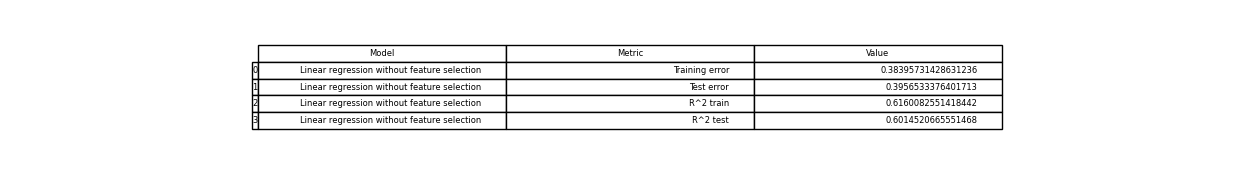

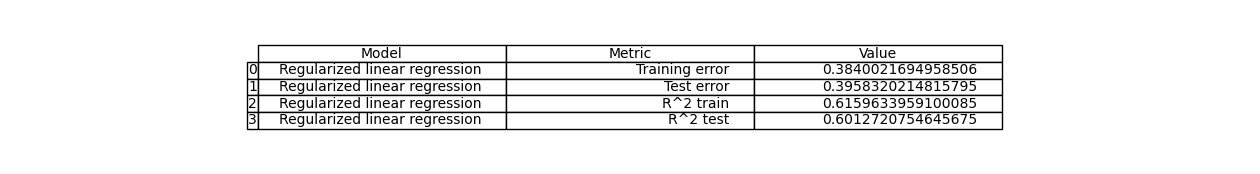

In [8]:
# Store the above information in variables and make tables.
linear_regression_info = [
    ('Linear regression without feature selection', 'Training error', Error_train.mean()),
    ('Linear regression without feature selection', 'Test error', Error_test.mean()),
    ('Linear regression without feature selection', 'R^2 train', (Error_train_nofeatures.sum() - Error_train.sum()) / Error_train_nofeatures.sum()),
    ('Linear regression without feature selection', 'R^2 test', (Error_test_nofeatures.sum() - Error_test.sum()) / Error_test_nofeatures.sum())
]

regularized_linear_regression_info = [
    ('Regularized linear regression', 'Training error', Error_train_rlr.mean()),
    ('Regularized linear regression', 'Test error', Error_test_rlr.mean()),
    ('Regularized linear regression', 'R^2 train', (Error_train_nofeatures.sum() - Error_train_rlr.sum()) / Error_train_nofeatures.sum()),
    ('Regularized linear regression', 'R^2 test', (Error_test_nofeatures.sum() - Error_test_rlr.sum()) / Error_test_nofeatures.sum())
]

# Create DataFrames
linear_regression_df = pd.DataFrame(linear_regression_info, columns=['Model', 'Metric', 'Value'])
regularized_linear_regression_df = pd.DataFrame(regularized_linear_regression_info, columns=['Model', 'Metric', 'Value'])

# Set up the matplotlib figures
fig1, ax1 = plt.subplots(figsize=(16, 2))
fig2, ax2 = plt.subplots(figsize=(16, 2))

# Hide the axes
ax1.axis('off')
ax2.axis('off')

# Create tables and add them to the subplot
table(ax1, linear_regression_df, loc='center', colWidths=[0.2, 0.2, 0.2])
table(ax2, regularized_linear_regression_df, loc='center', colWidths=[0.2, 0.2, 0.2])

# Save the figures as images
fig1.savefig('linear_regression_table.png', bbox_inches='tight', pad_inches=0.05)
fig2.savefig('regularized_linear_regression_table.png', bbox_inches='tight', pad_inches=0.05)

plt.show()


In [30]:
# Making our baseline model and our Artificial Neural Network

#For baseline we take the mean of the value we want to predict
class BaselineRegression():
    def fit(self, features, target):
        self.mean_target = np.mean(target)

    def predict(self, features):
        return self.mean_target

#Artificial Neural Network
class ANNRegression():
    def __init__(self, hidden_units, criterion=nn.MSELoss()):
        self.criterion = criterion
        self.max_iterations = 1000
        self.hidden_units = hidden_units

#Architecture
    def fit(self, features, target):
        features = torch.Tensor(features)
        target = torch.Tensor(target)
        model = lambda: nn.Sequential(
            nn.Linear(features.shape[1], self.hidden_units),
            nn.Tanh(),
            nn.Linear(self.hidden_units, 1),
        )
        self.neural_net, _, _ = train_neural_net(
            model, self.criterion, X=features, y=target, n_replicates=1, max_iter=self.max_iterations
        )

    def predict(self, features, target_test):
        features = torch.Tensor(features)
        predicted_target = self.neural_net(features)
        squared_error = (predicted_target.float() - target_test.float()) ** 2
        mean_squared_error = (torch.sum(squared_error).float() / len(target_test)).data.numpy()
        return predicted_target.detach().numpy(), mean_squared_error

    
def error_function(y_hat, y):
    return np.power(y - y_hat, 2).mean()

#Implementing two layer cross validation in our ANN
def two_layer_cross_validation(regression_models, parameter_types, features, target, K_outer=10, K_inner=10):
    test_errors = np.zeros((K_outer, len(regression_models) * 2))
    predicted_targets_list = []
    true_targets_list = []

    for _ in range(len(regression_models)):
        predicted_targets_list.append([])

    K_outer_fold = model_selection.KFold(n_splits=K_outer, shuffle=True)

    for i, (par_index, test_index) in enumerate(K_outer_fold.split(features, target)):
        print("Outer fold {} of {}".format(i + 1, K_outer))

        K_inner_fold = model_selection.KFold(n_splits=K_inner, shuffle=True)

        features_par = features[par_index, :]
        target_par = target[par_index]

        features_test = features[test_index, :]
        target_test = target[test_index]
        true_targets_list.append(target_test)

        for m, (model_type, models) in enumerate(regression_models):
            validation_errors = np.zeros((K_inner, len(models)))

            for j, (train_index, validation_index) in enumerate(K_inner_fold.split(features_par, target_par)):
                features_train = features_par[train_index, :]
                target_train = target_par[train_index]

                features_validation = features_par[validation_index, :]
                target_validation = target_par[validation_index]

                for k, (name, parameter, model) in enumerate(models):
                    model.fit(features_train, target_train)

                    if model_type == 'ANN':
                        predicted_target, mean_squared_error = model.predict(features_validation, torch.Tensor(target_validation))
                        validation_errors[j, k] = mean_squared_error
                    else:
                        predicted_target = model.predict(features_validation)
                        validation_errors[j, k] = error_function(predicted_target, target_validation)

            inner_generalization_errors = validation_errors.sum(axis=0)
            best_model_index = np.argmin(inner_generalization_errors)
            best_model_name, best_model_parameter, best_regression_model = models[best_model_index]

            if model_type == 'Base Line':
                best_regression_model.fit(features_par, target_par)
                predicted_target = np.ones(len(target_test)) * best_regression_model.predict(features_test)
            elif model_type == 'ANN':
                best_regression_model.fit(features_par, target_par)
                predicted_target, mean_squared_error = best_regression_model.predict(features_test, torch.Tensor(target_test))
            else:
                best_regression_model.fit(features_par, target_par)
                predicted_target = best_regression_model.predict(features_test)

            predicted_targets_list[m].append(predicted_target.squeeze())

            if model_type == 'ANN':
                test_errors[i, m * 2 + 1] = mean_squared_error
            else:
                test_errors[i, m * 2 + 1] = error_function(predicted_target, target_test)

            test_errors[i, m * 2] = best_model_parameter

        test_errors_folds = pd.DataFrame.from_records(
            data=test_errors,
            columns=sum([[parameter_types[i],regression_models[i][0]] for i in range(len(regression_models))],[]))
        test_errors_folds = test_errors_folds.drop('Nothing', axis=1)

    return test_errors_folds, predicted_targets_list, true_targets_list

In [ ]:

#load the data that will be used for prediction

X = df.drop(columns="Concrete compressive strength(MPa, megapascals) ").values

#load the data the we want to predict
y = df["Concrete compressive strength(MPa, megapascals) "].values.reshape(-1, 1)

#Choose ranges for lambda and hidden_units
lambdas = np.logspace(-1, 2, 10)
hidden_units = np.arange(1, 16)

#We do this for all models Baseline,Linear and ANN
model_types = [
  ("Linear Model", [("Linear Model, lambda = {}".format(l), l, lm.Ridge(alpha=l)) for l in lambdas]),
  ("ANN", [("ANN, h_u = {}", h_u, ANNRegression(hidden_units = h_u)) for h_u in hidden_units]),
  ("Base Line", [("Base Line", None, BaselineRegression())])
]

parameter_types = ["Lambda", "Hidden units","Nothing"]

test_errors_regression, predicted_values_regression, true_values_regression = two_layer_cross_validation(model_types, parameter_types, X, y)

Outer fold 1 of 10
Outer fold 2 of 10
Outer fold 3 of 10
Outer fold 4 of 10
Outer fold 5 of 10
Outer fold 6 of 10
Outer fold 7 of 10
Outer fold 8 of 10
Outer fold 9 of 10
Outer fold 10 of 10


     Lambda  Linear Model  Hidden units       ANN  Base Line
0  1.000000      0.417505          15.0  0.208790   0.983742
1  1.000000      0.474957          15.0  0.215670   1.103616
2  1.000000      0.299305          14.0  0.171003   0.684226
3  1.000000      0.446088          15.0  0.162219   1.246113
4  2.154435      0.433820          15.0  0.183138   0.897716
5  1.000000      0.399547          13.0  0.180151   0.891889
6  1.000000      0.407171          15.0  0.242525   0.971267
7  1.000000      0.352808          14.0  0.227054   1.183314
8  1.000000      0.314253          15.0  0.180437   0.836296
9  1.000000      0.388435          15.0  0.198543   1.210181
P-value for the null hypothesis: ANN = LM: [2.49008974e-025 4.31501163e-002 5.22346464e-009 ... 1.72960759e-137
 8.85876115e-028 2.43950596e-028]
0.95 % Confidence interval for Z = E_ANN - E_LM: (array([ 0.13617774, -0.02387924,  0.11026365, ...,  0.15585957,
        0.13775972,  0.13809093]), array([0.19797863, 0.35803561, 0.2

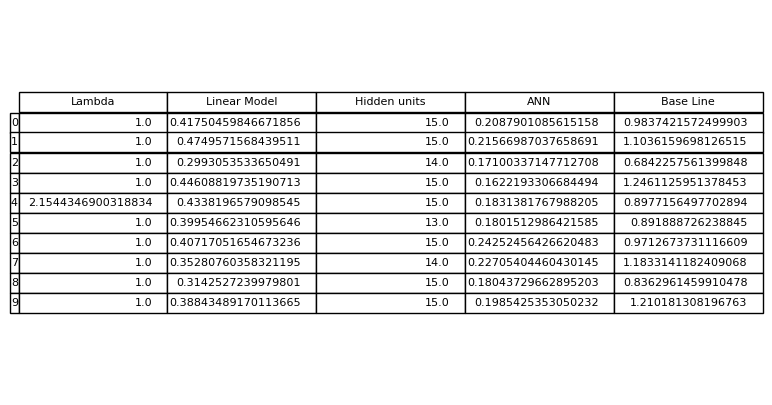

In [33]:
#Regression part b 2. Produce a table akin to Table 1


# Display the DataFrame with test errors
print(test_errors_regression)

# Convert the test_errors_regr DataFrame to a table
table_data = test_errors_regression.to_numpy().tolist()
column_labels = test_errors_regression.columns
row_labels = [str(i) for i in range(len(test_errors_regression))]

# Create the table
figure, axis = plt.subplots(figsize=(8, 5))
table = axis.table(cellText=table_data, colLabels=column_labels, rowLabels=row_labels, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)  # Adjust the scaling as needed

# Save the table as a picture
plt.axis('off')
plt.savefig('test_errors_regr_table.png', bbox_inches='tight')

# Concatenate predicted values and true values
predicted_linear_model = np.concatenate(predicted_values_regression[0])
predicted_neural_network = np.concatenate(predicted_values_regression[1])
predicted_baseline = np.concatenate(predicted_values_regression[2])
true_values = np.concatenate(true_values_regression)

# Calculate squared errors
squared_error_linear_model = (predicted_linear_model - true_values) ** 2
squared_error_neural_network = (predicted_neural_network - true_values) ** 2
squared_error_baseline = (predicted_baseline - true_values) ** 2

alpha = 0.05  # significance

# Calculate McNemar's test for Neural Network vs. Linear Model
z_ann_vs_lm = squared_error_neural_network - squared_error_linear_model
CI_ann_vs_lm = st.t.interval(1 - alpha, len(z_ann_vs_lm) - 1, loc=np.mean(z_ann_vs_lm), scale=st.sem(z_ann_vs_lm))
p_ann_vs_lm = st.t.cdf(-np.abs(np.mean(z_ann_vs_lm)) / st.sem(z_ann_vs_lm), df=len(z_ann_vs_lm) - 1)

# Calculate McNemar's test for Neural Network vs. Baseline
z_ann_vs_bl = squared_error_neural_network - squared_error_baseline
CI_ann_vs_bl = st.t.interval(1 - alpha, len(z_ann_vs_bl) - 1, loc=np.mean(z_ann_vs_bl), scale=st.sem(z_ann_vs_bl))
p_ann_vs_bl = st.t.cdf(-np.abs(np.mean(z_ann_vs_bl)) / st.sem(z_ann_vs_bl), df=len(z_ann_vs_bl) - 1)

# Calculate McNemar's test for Linear Model vs. Baseline
z_lm_vs_bl = squared_error_linear_model - squared_error_baseline
CI_lm_vs_bl = st.t.interval(1 - alpha, len(z_lm_vs_bl) - 1, loc=np.mean(z_lm_vs_bl), scale=st.sem(z_lm_vs_bl))
p_lm_vs_bl = st.t.cdf(-np.abs(np.mean(z_lm_vs_bl)) / st.sem(z_lm_vs_bl), df=len(z_lm_vs_bl) - 1)

# Display results
print("P-value for the null hypothesis: ANN = LM:", p_ann_vs_lm)
print(1 - alpha, "% Confidence interval for Z = E_ANN - E_LM:", CI_ann_vs_lm)
print("")
print("P-value for the null hypothesis: ANN = BL:", p_ann_vs_bl)
print(1 - alpha, "% Confidence interval for Z = E_ANN - E_BL:", CI_ann_vs_bl)
print("")
print("P-value for the null hypothesis: LM = BL:", p_lm_vs_bl)
print(1 - alpha, "% Confidence interval for Z = E_LM - E_BL:", CI_lm_vs_bl)

print(z_ann_vs_lm.mean())
print(z_ann_vs_bl.mean())
print(z_lm_vs_bl.mean())


Classification:

In [44]:
#1.Multiclass classification problem, we will have three classes for low,medium and high concrete strength



# Load the data
df = pd.read_excel(r"C:\Users\Thoma\ML\concrete_compressive_strength\Concrete_Data.xls")

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to your data and transform it
X_standardized = scaler.fit_transform(df.iloc[:, :-1])

# Create a new DataFrame with the standardized data
df_std = pd.DataFrame(X_standardized, columns=df.columns[:-1])


# Define target classes based on the concrete strength
df_std['Strength'] = np.select(
    [df[df.columns[8]] < 25,
     df[df.columns[8]] < 55,
     df[df.columns[8]] >= 55],
    [0, 1, 2])

# Features
X = df_std.iloc[:, :-1].values

# Target variable (multiclass)
y = df_std['Strength'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression with hyperparameter tuning
param_grid_logreg = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=5)
grid_search_logreg.fit(X_train, y_train)
best_logreg = grid_search_logreg.best_estimator_

# Print the best hyperparameter for Logistic Regression
print("Best Logistic Regression Hyperparameter:", best_logreg.get_params()['C'])

# Artificial Neural Network with hyperparameter tuning (hidden layer size)
param_grid_ann = {'hidden_layer_sizes': [(1,),(5,), (10,), (15,), (20,)]}
grid_search_ann = GridSearchCV(MLPClassifier(max_iter=1000), param_grid_ann, cv=5)
grid_search_ann.fit(X_train, y_train)
best_ann = grid_search_ann.best_estimator_

# Print the best hyperparameter for ANN
print("Best ANN Hyperparameter (Hidden Layer Size):", best_ann.get_params()['hidden_layer_sizes'])

# Baseline model
majority_class = np.argmax(np.bincount(y_train))
y_pred_baseline = np.full_like(y_test, fill_value=majority_class)

Best Logistic Regression Hyperparameter: 100


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

Best ANN Hyperparameter (Hidden Layer Size): (20,)


In [45]:

# Load the data
df = pd.read_excel(r"C:\Users\Thoma\ML\concrete_compressive_strength\Concrete_Data.xls")

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to your data and transform it
X_standardized = scaler.fit_transform(df.iloc[:, :-1])

# Create a new DataFrame with the standardized data
df_std = pd.DataFrame(X_standardized, columns=df.columns[:-1])

# Define target classes based on the concrete strength
df_std['Strength'] = np.select(
    [df[df.columns[8]] < 25,
     df[df.columns[8]] < 55,
     df[df.columns[8]] >= 55],
    [0, 1, 2])

# Features
X = df_std.iloc[:, :-1].values

# Target variable (multiclass)
y = df_std['Strength'].values

# Number of outer and inner folds
K1 = 10
K2 = 10

# Outer cross-validation
K1fold = model_selection.KFold(n_splits=K1, shuffle=True, random_state=42)


#Classification 2.
# Initialize lists to store results
model_names = ['Logistic Regression', 'ANN', 'Baseline']
param_values = []
error_rates = []

# Outer loop
for i, (train_index, test_index) in enumerate(K1fold.split(X, y)):
    print("Outer fold {} of {}".format(i+1, K1))

    # Training and test sets for outer fold
    X_train_outer, X_test_outer = X[train_index], X[test_index]
    y_train_outer, y_test_outer = y[train_index], y[test_index]

    # Inner cross-validation
    K2fold = model_selection.KFold(n_splits=K2, shuffle=True, random_state=42)

    # Lists to store inner results
    inner_param_values = []
    inner_error_rates = []

    # Logistic Regression
    param_grid_logreg = {'C': [100]}
    grid_search_logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_logreg, cv=K2)
    grid_search_logreg.fit(X_train_outer, y_train_outer)
    best_logreg = grid_search_logreg.best_estimator_

    inner_param_values.append(best_logreg.get_params()['C'])
    y_pred_logreg_outer = best_logreg.predict(X_test_outer)
    error_rate_logreg = 1 - accuracy_score(y_test_outer, y_pred_logreg_outer)
    inner_error_rates.append(error_rate_logreg)

    # Artificial Neural Network
    param_grid_ann = {'hidden_layer_sizes': [(20,)]}
    grid_search_ann = GridSearchCV(MLPClassifier(max_iter=1000), param_grid_ann, cv=K2)
    grid_search_ann.fit(X_train_outer, y_train_outer)
    best_ann = grid_search_ann.best_estimator_

    inner_param_values.append(best_ann.get_params()['hidden_layer_sizes'])
    y_pred_ann_outer = best_ann.predict(X_test_outer)
    error_rate_ann = 1 - accuracy_score(y_test_outer, y_pred_ann_outer)
    inner_error_rates.append(error_rate_ann)

    # Baseline model
    dummy = DummyClassifier(strategy='stratified')
    dummy.fit(X_train_outer, y_train_outer)
    y_pred_dummy_outer = dummy.predict(X_test_outer)

    inner_param_values.append(None)  # No hyperparameter for the baseline
    error_rate_baseline = 1 - accuracy_score(y_test_outer, y_pred_dummy_outer)
    inner_error_rates.append(error_rate_baseline)

    # Store inner results
    param_values.append(inner_param_values)
    error_rates.append(inner_error_rates)


Outer fold 1 of 10


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

Outer fold 2 of 10


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

Outer fold 3 of 10


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

Outer fold 4 of 10


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

Outer fold 5 of 10


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

Outer fold 6 of 10


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

Outer fold 7 of 10


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

Outer fold 8 of 10


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

Outer fold 9 of 10


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

Outer fold 10 of 10


c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Thoma\ML\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Conver

           Logistic Regression                      ANN             Baseline  \
                        Lambda Error Rate Hidden layers Error Rate Parameter   
Outer Fold                                                                     
0                          100   0.184466         (20,)   0.097087      None   
1                          100   0.223301         (20,)   0.135922      None   
2                          100   0.184466         (20,)   0.097087      None   
3                          100   0.174757         (20,)   0.165049      None   
4                          100   0.213592         (20,)   0.145631      None   
5                          100   0.145631         (20,)   0.077670      None   
6                          100   0.194175         (20,)   0.116505      None   
7                          100   0.223301         (20,)   0.165049      None   
8                          100   0.194175         (20,)   0.116505      None   
9                          100   0.24271

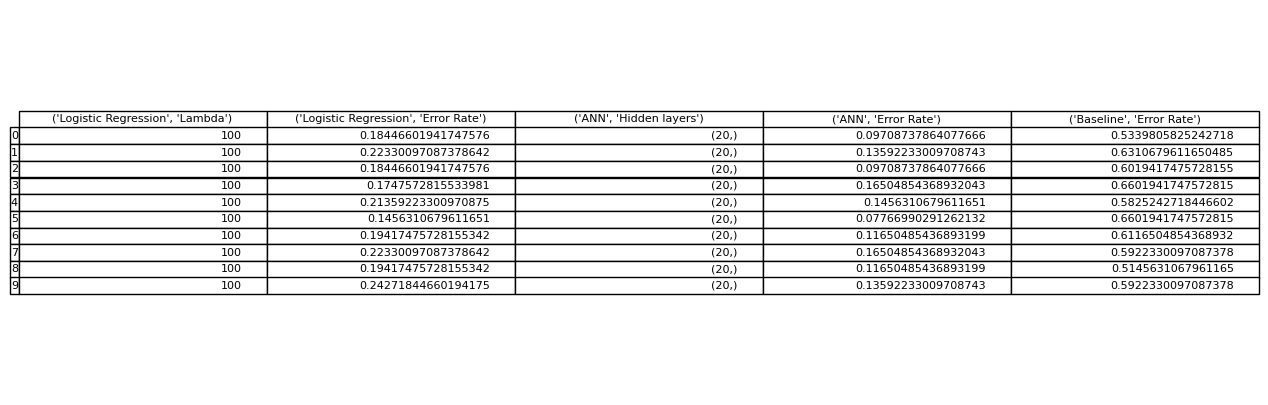

In [46]:
#Classification 3


# Create a DataFrame to display the results
result_df = pd.DataFrame(error_rates, columns=pd.MultiIndex.from_product([model_names, ['Error Rate']]))
result_df.index.name = 'Outer Fold'
result_df.insert(0, ('Logistic Regression', 'Lambda'), [param[0] for param in param_values])
result_df.insert(2, ('ANN', 'Hidden layers'), [param[1] for param in param_values])
result_df.insert(4, ('Baseline', 'Parameter'), [param[2] for param in param_values])# Display the results
print(result_df)
result_df = result_df.drop(columns= result_df.columns[4])



# Convert the test_errors_regr DataFrame to a table
table_data = result_df.to_numpy().tolist()
col_labels = result_df.columns
row_labels = [str(i) for i in range(len(result_df))]


# Create the table
fig, ax = plt.subplots(figsize=(8, 5))
table = ax.table(cellText=table_data, colLabels=col_labels, rowLabels=row_labels, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(2, 1)  # Adjust the scaling as needed
# Save the table as a picture
plt.axis('off')
plt.savefig('test_errors_regr_table.png', bbox_inches='tight')


#Classification 4.

# We choose McNemar's test for pairwise comparisons
contingency_lm_ann = mcnemar(y_test_outer, y_pred_logreg_outer, y_pred_ann_outer)
p_lm_vs_ann = contingency_lm_ann[0]

contingency_lm_bl = mcnemar(y_test_outer, y_pred_logreg_outer, y_pred_dummy_outer)
p_lm_vs_bl = contingency_lm_bl[0]

contingency_ann_bl = mcnemar(y_test_outer, y_pred_ann_outer, y_pred_dummy_outer)
p_ann_vs_bl = contingency_ann_bl[0]

# Print p-values
print("\nP-value for the null hypothesis: Logistic Regression = ANN:", p_lm_vs_ann)
print("P-value for the null hypothesis: Logistic Regression = Baseline:", p_lm_vs_bl)
print("P-value for the null hypothesis: ANN = Baseline:", p_ann_vs_bl)


In [47]:
# Print the coefficients and their corresponding feature names
coefficients = best_logreg.coef_
feature_names = df_std.columns[:-1]

for feature, coef in zip(feature_names, coefficients[0]):
    print(f"{feature}: {coef}")


Cement (component 1)(kg in a m^3 mixture): -2.994670954527339
Blast Furnace Slag (component 2)(kg in a m^3 mixture): -2.085338593876033
Fly Ash (component 3)(kg in a m^3 mixture): -1.2804460972243605
Water  (component 4)(kg in a m^3 mixture): 0.46145669236004505
Superplasticizer (component 5)(kg in a m^3 mixture): -0.35905726579509384
Coarse Aggregate  (component 6)(kg in a m^3 mixture): -0.4664568088829926
Fine Aggregate (component 7)(kg in a m^3 mixture): -0.5152330759043611
Age (day): -5.989246620858289
